# Creating warm start forcing data

We want to add or replace soil data in the forcing data files. We show an example here, where we take the soil data from the output file of a remo run and add this to the forcing file of another run for use as initial lateral boundary conditions. 

In [66]:
import xarray as xr
import pyremo as pr

afile = xr.open_dataset("/work/ch0636/remo/forcing-data/EUR-11/ERA5/1980/a056530a1980010100_no_soil.nc")
tfile = pr.remo_ds.open_remo_dataset("/work/ch0636/remo/forcing-data/EUR-11/ERA5/1980/e056524t1980010100", update_meta=True, parse_time=True)

The output dataset (`tfile`) contains the spin up soil data. This could also come from another point in time of the same run or another run. The soil is defined by a number of codes or variable names:

In [67]:
soil_codes = [54,55,56,206,207,208,209,232,170,183,84,140,194,141]
soil_vars = [pr.codes.get_dict(c)['variable'] for c in soil_codes]
soil_vars

['TSL',
 'TSW',
 'TSI',
 'TSN',
 'TD3',
 'TD4',
 'TD5',
 'GLAC',
 'TD',
 'TDCL',
 'QDBL',
 'WS',
 'WL',
 'SN']

Now we copy and replace the data from the output file (`tfile`) in the forcing file (`afile`).

In [68]:
fillvars = ['TSW', 'SEAICE', 'TSI']

for var in soil_vars:
    afile[var] = tfile[var]
    # we have to set the encoding here explicitly, otherwise xarray.to_netcdf will
    # encode missing values by NaN, which will crash REMO...
    if var in fillvars:
        afile[var].encoding['_FillValue'] = 1.e20
    else:
        afile[var].encoding['_FillValue'] = None

Now, we can write that data back to netCDF format.

In [69]:
afile.to_netcdf("/work/ch0636/remo/forcing-data/EUR-11/ERA5/1980/a056530a1980010100_warm_soil.nc")

We should check the data with a simple plot, we will look at the temperatures here.

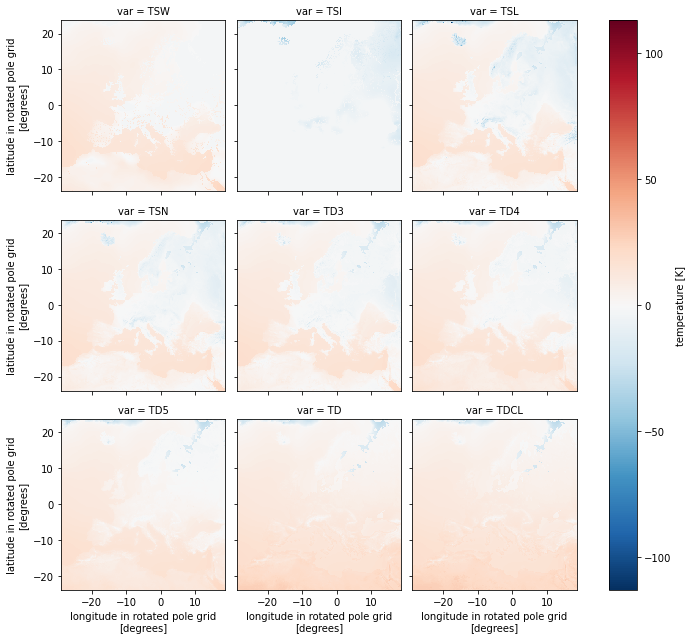

In [70]:
def get_temps(ds):
    temps = ['TSW', 'TSI', 'TSL', 'TSN', 'TD3', 'TD4', 'TD5', 'TD', 'TDCL']
    dim=xr.DataArray(data=temps, dims='var', name='var')
    tda = xr.concat([ds[var]-273.5 for var in temps], dim=dim)
    tda.name = 'temperature'
    return tda

get_temps(afile).plot(col='var', col_wrap=3)

## Adding static fields to the forcing file

The initial forcing file also has to contain static fields (e.g., like the land sea mask or the orography). Remo will read these fields in from the first initial forcing file.

In [71]:
from pyremo import data as rd
surflib = rd.surflib('EUR-11', update_meta=True)
surflib

<xarray.Dataset>
Dimensions:       (rlat: 433, rlon: 433)
Coordinates:
  * rlon          (rlon) float64 -28.93 -28.82 -28.71 ... 18.38 18.48 18.59
  * rlat          (rlat) float64 -23.93 -23.82 -23.71 ... 23.38 23.48 23.59
Data variables: (12/14)
    rotated_pole  int32 ...
    FIB           (rlat, rlon) float32 ...
    BLA           (rlat, rlon) float32 ...
    AZ0           (rlat, rlon) float32 ...
    ALB           (rlat, rlon) float32 ...
    VGRAT         (rlat, rlon) float32 ...
    ...            ...
    FOREST        (rlat, rlon) float32 ...
    FAO           (rlat, rlon) float32 ...
    WSMX          (rlat, rlon) float32 ...
    BETA          (rlat, rlon) float32 ...
    WMINLOK       (rlat, rlon) float32 ...
    WMAXLOK       (rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 01 12:03:07 2020: cdo -f nc copy lib_EUR-11_frac li...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

We have to take care if the coordinate values in the afile and surface library are not *exactly* the same. To make sure, we set `join="override"` to simply use the coordinate values from the afile.

In [72]:
afile = xr.merge([afile, surflib], join="override")
afile

<xarray.Dataset>
Dimensions:                     (lev: 27, lev_i: 28, rlat: 433, rlon: 433, time: 1)
Coordinates:
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * time                        (time) datetime64[ns] 1980-01-01
  * lev                         (lev) int64 1 2 3 4 5 6 7 ... 22 23 24 25 26 27
  * lev_i                       (lev_i) int64 1 2 3 4 5 6 ... 23 24 25 26 27 28
    lon                         (rlat, rlon) float64 ...
    lat                         (rlat, rlon) float64 ...
Data variables: (12/41)
    T                           (time, lev, rlat, rlon) float32 ...
    U                           (time, lev, rlat, rlon) float32 ...
    V                           (time, lev, rlat, rlon) float32 ...
    PS                          (time, rlat, rlon) float32 ...
    RF                          (time, lev, rlat, rlon) float32 ...
    TSW                         (time, rlat, rlon) float32 284.0 284.0 ... 271.4
    ...                          ...
    FOREST                      (rlat, rlon) float32 ...
    FAO                         (rlat, rlon) float32 ...
    WSMX                        (rlat, rlon) float32 ...
    BETA                        (rlat, rlon) float32 ...
    WMINLOK                     (rlat, rlon) float32 ...
    WMAXLOK                     (rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      preprocessing with pyremo = 0.1.0
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [73]:
afile.to_netcdf("/work/ch0636/remo/forcing-data/EUR-11/ERA5/1980/a056530a1980010100.nc")